- $q(x)$：from student model，$p(x)$：from teacher model,
- 其次对于 $q(x), p(x)$ 在计算时需要加温度,
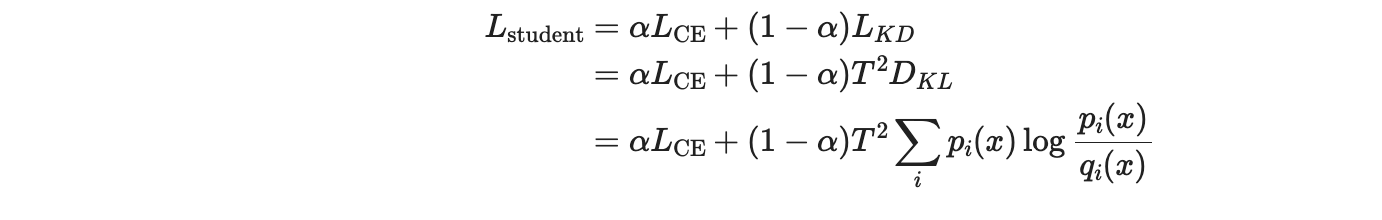
- 关于 `nn.KLDivLoss()`,
    - inputs ($q(x)$): log probabilities,
    - labels ($p(x)$): normal probabilities

In [4]:
from transformers import TrainingArguments, Trainer
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import wandb

In [5]:
# 定义超参数
class DistillTrainingArguments(TrainingArguments):
    # TrainingArguments: @dataclass
    # 增加两个 KD 所需的参数参数
    def __init__(self, *args, alpha=0.5, temperature=2., **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature
        
# 定义训练过程
class DistillTrainer(Trainer):
    
    def __init__(self, *args, teacher_model=None, **kwargs):
        # 增加 teacher_model 参数
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        
    # 重写 trainer 中核心方法
    # forward 计算损失
    def compute_loss(self, model, inputs, return_outputs=False):
        s_output = model(**inputs)
        s_ce = s_output.loss
        s_logits = s_output.logits
        
        with torch.no_grad():
            t_output = self.teacher_model(**inputs)
            t_logits = t_output.logits
        
        loss_kl_fct = nn.KLDivLoss(reduction='batchmean')
        loss_kd = self.args.temperature**2 * loss_kl_fct(F.log_softmax(s_logits/self.args.temperature, dim=-1), 
                                                        F.softmax(t_logits/self.args.temperature, dim=-1))
        loss = self.args.alpha * s_ce + (1-self.args.alpha) * loss_kd
        return (loss, s_output) if return_outputs else loss

## pipeline

In [ ]:
from datasets import load_dataset
clinc = load_dataset("clinc_oos", "plus")

clinc
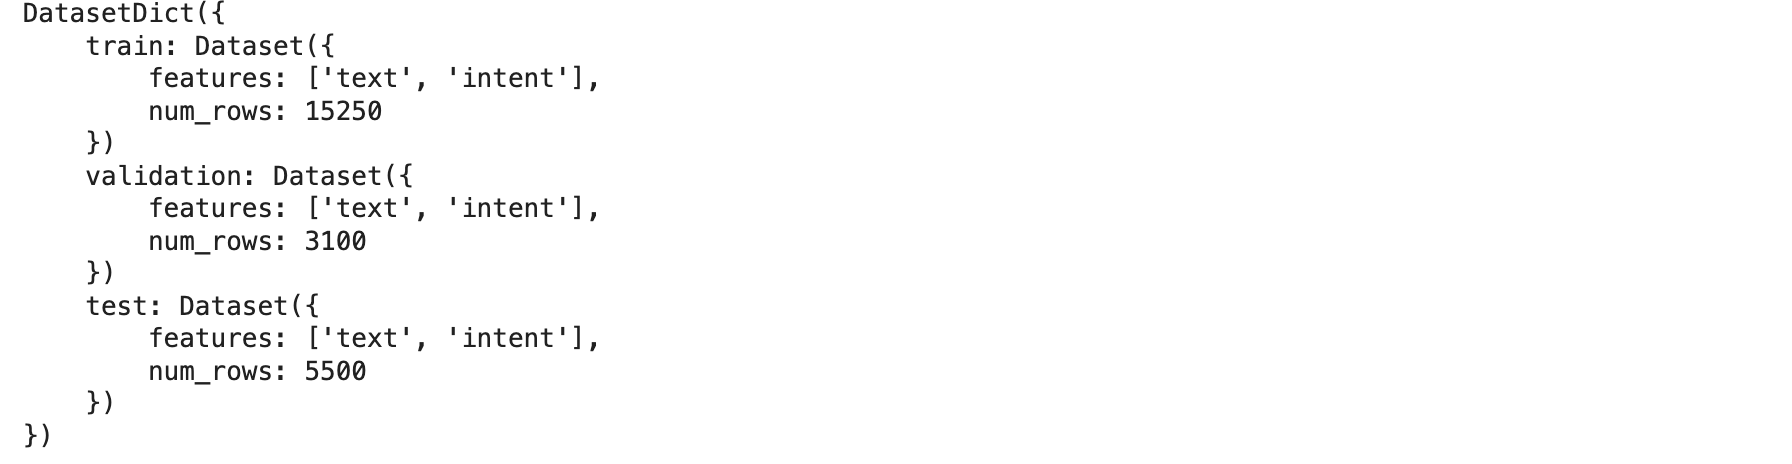

In [ ]:
clinc['train'][:10]

In [ ]:
intents = clinc['train'].features['intent']
num_labels = intents.num_classes
num_labels

### Student model 初始化


In [ ]:
from transformers import AutoConfig, AutoTokenizer
from transformers import AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

s_ckpt = 'distilbert-base-uncased'
s_tokenizer = AutoTokenizer.from_pretrained(s_ckpt)

t_ckpt = 'transformersbook/bert-base-uncased-finetuned-clinc'
t_model = AutoModelForSequenceClassification.from_pretrained(t_ckpt, num_labels=num_labels).to(device)

In [ ]:
clinc_enc = clinc.map(lambda batch: s_tokenizer(batch['text'], truncation=True), 
                      batched=True, 
                      remove_columns=["text"]
                     )
clinc_enc = clinc_enc.rename_columns({'intent': 'labels'}) # 重命名
clinc_enc

In [ ]:
batch_size = 64
s_training_args = DistillTrainingArguments(output_dir='distilbert-base-uncased-ft-clinc', 
                                           evaluation_strategy='epoch', num_train_epochs=5, 
                                           learning_rate=3e-4, 
                                           per_device_train_batch_size=batch_size, 
                                           per_device_eval_batch_size=batch_size, 
                                           alpha=0.5, weight_decay=0.01, 
                                           logging_strategy='epoch',
                                           push_to_hub=False)
s_config = AutoConfig.from_pretrained(s_ckpt, num_labels=num_labels, 
                                      id2label=t_model.config.id2label, label2id=t_model.config.label2id)
# s_config

In [ ]:
def student_init():
    return AutoModelForSequenceClassification.from_pretrained(s_ckpt, config=s_config).to(device)


### trainer.train


In [ ]:
# from datasets import load_metric
# accuracy_score = load_metric('accuracy')
# SequenceClassification
import evaluate
accuracy_score = evaluate.load('accuracy')

# trainer 重要的回调函数，非成员函数
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=-1)
    return accuracy_score.compute(references=labels, predictions=predictions)

distill_trainer = DistillTrainer(model_init=student_init, teacher_model=t_model, args=s_training_args, 
                                 train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'], 
                                 compute_metrics=compute_metrics, tokenizer=s_tokenizer)
distill_trainer.train()

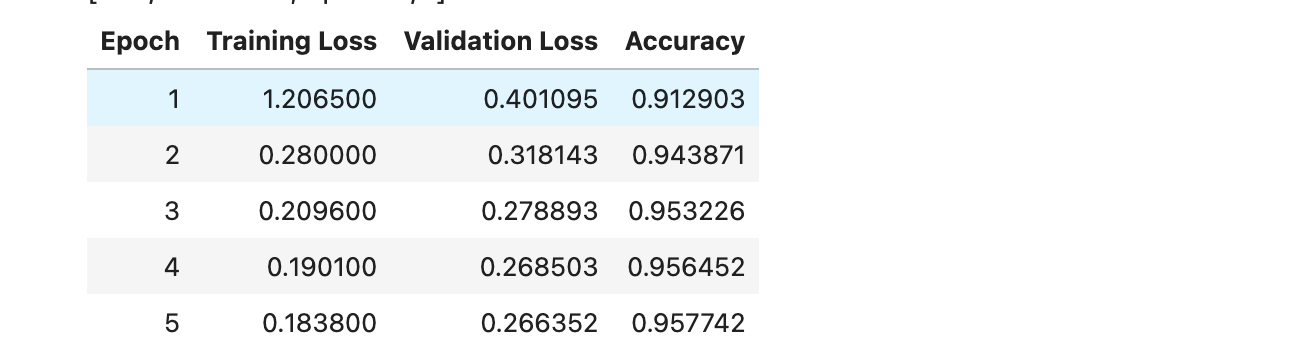
TrainOutput(global_step=600, training_loss=0.41400583267211916, metrics={'train_runtime': 76.8404, 'train_samples_per_second': 992.317, 'train_steps_per_second': 7.808, 'total_flos': 456233053284036.0, 'train_loss': 0.41400583267211916, 'epoch': 5.0})

### 使用

In [ ]:
from transformers import pipeline

# ft_ckpt = 'lanchunhui/distilbert-base-uncased-ft-clinc'
# distill_trainer.push_to_hub('finetune completed!')

pipe = pipeline('text-classification', model='./distilbert-base-uncased-ft-clinc/')